In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
#import gym
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from itertools import combinations
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.special import iv  # Modified Bessel function of the first kind
from scipy.stats import rice
%matplotlib inline

2025-07-02 13:44:19.786082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 13:44:19.786158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 13:44:19.812175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 13:44:19.883886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 13:44:22.259146: W tensorflow/compiler/tf2

# Mathematical Workings

# 1. Problem Formulation 
UAV should serve the following roles and purposes:
1. Base Station
2. Relay
3. Signal Jammer

Objective for optimisation:
Minimum average secrecy rate
Achieve this by optimising:
1. UAV Trajectory
2. UAV Transmit Power Allocation
3. UAV Energy Efficiency

Subject to the following constraints:
1. UAV Energy Consumption
2. UAV Mission Time (secrecy & energy)
3. Environmental Conditions (weather, LoS, infrastructure, etc.)
4. UAV Altitude & Range
5. Rician Channel Fading (kind of factors into communications range, signal power, etc.)
6. Shannon Limit/Data Rates

## Project Roadmap
### i. Classical Implementation
1. Implement the optimisation problem using frameworks like Pyomo or just "manual" calculations as well as using ML/DRL for comparison with the LQ-DRL approach
2. Test the optimisation algorithm with different scenarios (urban vs clear/rural environment and with different weather conditions if possible)
3. Determine which parts of the algorithm ought to be solved with the use of quantum computing (main focus should be the LQ-DRL approach as per Anshu's recommendation)
4. Implement the quantum/classical hybrid algorithm and compare the results with the classical method in terms of different metrics 
5. Compare different embedding techniques and results
6. Try to ameliorate/append the LQ-DRL algorithm from Silvirianti et. al (2025) -- vague for now, clarify as you go on

## i. Objective Function
Horizontal location of UAV-BS at time slot n:
\
$
\Large
w_{UAV} 
$
\
Subcarrier Scheduling
\
$
\Large
A \triangleq \begin{Bmatrix} {\alpha_{k, i}[n], \forall k, i, n} \end{Bmatrix}
$ 
\
Power Consumption
\
$
\Large
P \triangleq \begin{Bmatrix} {P_{U, i}[n], \forall k, i, n} \end{Bmatrix}
$
\
UAV Trajectory 
\
$
\Large
Q \triangleq \begin{Bmatrix} {q_{U}[n], \forall n} \end{Bmatrix}
$
\
Thus, the objective function aims to maximise these parameters such that the secret key rate exchange is, in turn, maximised and optimised as well. This can be expressed using the following objective function:
\
$
\Large
\underset{w_{UAV}, A, P, Q}{max} \frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{I} R_{k, i}^{sec} [n], \forall k
$
\
s.t.
\
$
P \leq P_{sum}
$

# Mathematical Workings
## Energy Consumption Model
Adapted from Silvirianti et. al (2025)
\
$
\Large
E_{cons}(t) = \sum_{n=1}^{N} \sum_{k=1}^{K_n} \left (\frac{\sum_{i=1}^{2} n_{i} g c(t)}{\mathbf{k}\textit{z}} + 
\frac{((\sum_{i=1}^{2}n_i)g)^{\frac{3}{2}}}{\sqrt{2 z \zeta \theta}} +
\Lambda \frac{c(t)}{v(t)} + 
P_{k, n}^{Tx}(t) R_{k, n}(t) \right)
$
\
Where
$
n_i = 
$
UAV framework & battery
\
$
g = 
$
Acceleration due to gravity ($9.81 m s^{-2}$)
\
$
c(t) = \sqrt{\sum_{i=t-1}^{t} (x_i - x_{i-1})^{2} + (y_i - y_{i-1})^{2} + (H_i - H_{i-1})^{2}}
$
\
i.e., $c(t)$ = The location of a UAV at time $t$
\
$
\mathbf{K} = 
$
Lift-to-Drag ratio
\
$
\textit{z} = 
$
Number of UAV Rotors
\
$
\zeta = 
$
Air Density
\
$
\theta = 
$
Spinning Blade of One Rotor
\
$
\Lambda = 
$
Avionics Power for UAV
\
$
v(t) = 
$
Velocity of UAV at time $t$
\
$
P_{k, n}^{Tx}(t) = 
$
Communication power of the $k^{th}$ user
\
$
R_{k, n}(t) = 
$
Achievable Sum Rate of $k^{th}$ user in $n^{th}$ group

### Lift-to-Drag Ratio
$
\Large
K = \left (\frac{L}{D} \right) = \frac{1}{2} \sqrt{\frac{\pi \epsilon AR}{C_{D, 0}}}
$
\
$ \epsilon = $ Span Efficiency Factor or Oswald Efficiency Number
\
$ AR = $ Aspect Ratio of the Wing
\
$ C_{D, 0} = $ Zero-Lift Drag Coefficient

## Energy Efficiency
$
\Large
\eta(T) = \int_{t=1}^{T} \frac{\sum_{n=1}^{N} \sum_{k=1}^{K_n} R_{k, n}(t)}{E_{cons}(t)} dt
$
\
Maximise $\eta(T)$ subject to
\
Allocated NOMA Group Power Constraint:
\
$
\sum_{n=1}^{N} \sum_{k=1}^{K_n} P_{k, n}^{Tx}(t) \le P_{UAV}^{Tx}
$
\
Power Coefficient Constraints
\
$
0 \lt \sum_{k=1}^{K_n} \delta_{k, n} \le 1
$
\
$
\delta_{1, n} \lt \dots \lt \delta_{K_n, n}
$
\
Rate of Transmission Constraint:
\
$
R_{k, n}(t) \ge R_{min}
$
\
UAV Range & Altitude Constraints:
\
$
x_{min} \le x(t) \le x_{max}
$
\
$
y_{min} \le y(t) \le y_{max}
$
\
$
H_{min} \le H(t) \le H_{max}
$

## Communication Channels
### Rician Channel Model
$
\Large
s(t) = cos(\omega_{c}t)
$
\
$
\Large
v(t) = C \cdot cos(\omega_{c}t) + \sum_{n=1}^{N} r_n cos(\omega_{c}t + f_n)
$
\
$
\Large
K = \frac{v^2}{2\sigma^2}
$
\
Where $v^2$ is the signal power in the direct path and $2\sigma^2$ is the signal power of the scattered paths, thus, $K$ is the ratio between these 2 quantities.
\
Statistically, this can be viewed as the most dominant LoS path in the channel (centre of a Bell curve distribution, i.e., the mean $\mu$) and the standard deviations either side of it ($\sigma$ in a statistical distribution). 
\
$
\Large
\Omega = v^2 + 2\sigma^2
$
\
$\Omega$ can be seen to be the total power from both paths. 
\
$
\Large
v^2 = \frac{K}{1+K}\Omega
$
\
$
\Large
2\sigma^2 = \frac{\Omega}{1+K}
$
\
The resulting PDF:
\
$
\Large
f(x) = \frac{2(K+1)x}{\Omega}exp\left(-K-\frac{(K+1)x^2}{\Omega}\right) I_0 \left (2 \sqrt{\frac{K(K+1)}{\Omega}}x \right)
$

## Deep Reinforcement Learning
Policy $\pi(s, a)$ is determined by the Agent.
\
Value of the policy is determined by the expectation value of the policy $\pi$ based on if the state starts in a particular state $s_0$ with a discount rate $\gamma$ at time $t$.  
\
$
\Large
V_{\pi}(s) = E(\sum_{t} \gamma^t r_t | s_0 = s) 
$
\
Problem is an optimisation problem to solve for $\pi$.
\
Markov Decision Process (MDP) is a probabilistic process for going from state $s_t$ to the next state $s_{t+1}$. 

In [16]:
%load_ext autoreload
%autoreload 2
from uav_secrecy_env3 import UAVSecrecyEnv

'''
env = UAVSecrecyEnv()
env = Monitor(env)
env = DummyVecEnv([lambda: env])
'''

env = UAVSecrecyEnv()

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)
model.save("ppo_uav_secrecy_3")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt

def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    masr_values = []

    for ep in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0
        episode_masr = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward

            # Compute MASR from the reward function
            masr_values.append(reward)  # Approximate since MASR is used in reward

        episode_rewards.append(total_reward)

    return episode_rewards, masr_values

In [9]:
eval_env = UAVSecrecyEnv()

model = PPO("MlpPolicy", eval_env, verbose=1)
model.learn(total_timesteps=5000)
model.save("ppo_uav_secrecy_4")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 109      |
| time/              |          |
|    fps             | 1071     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1         |
|    ep_rew_mean          | 109       |
| time/                   |           |
|    fps                  | 814       |
|    iterations           | 2         |
|    time_elapsed         | 5         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0141185 |
|    clip_fraction        | 0.187     |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.8     |
|    e

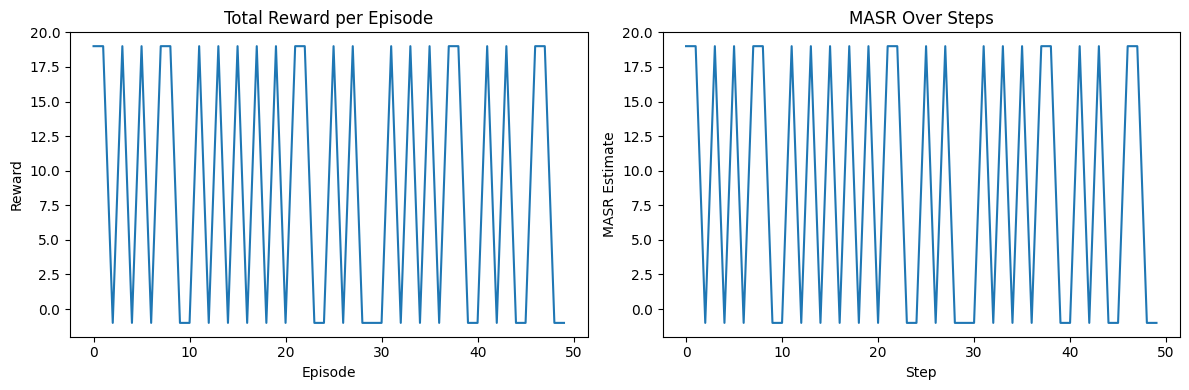

In [5]:
#rewards, masrs = evaluate_agent(model, eval_env, num_episodes=50)
rewards, masrs = evaluate_agent(model, env, num_episodes=50)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(masrs)
plt.title("MASR Over Steps")
plt.xlabel("Step")
plt.ylabel("MASR Estimate")

plt.tight_layout()
plt.show()

In [2]:
from mpl_toolkits.mplot3d import Axes3D

def render_trajectories(env):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, uav in enumerate(env.uavs):
        history = np.array(uav.history)
        ax.plot(history[:, 0], history[:, 1], history[:, 2], label=f"UAV-{i}")
        ax.scatter(history[-1, 0], history[-1, 1], history[-1, 2], marker='o')

    ax.set_xlim([0, env.xmax])
    ax.set_ylim([0, env.ymax])
    ax.set_zlim([env.zmin, env.zmax])
    ax.set_title("UAV Trajectories")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Altitude (Z)")
    ax.legend()
    plt.show()

In [3]:
def evaluate_agent_histories(model, env, num_episodes=10):
    episode_rewards = []
    all_histories = []

    for ep in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0
        uav_histories = [[] for _ in env.uavs]

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward

            for i, uav in enumerate(env.uavs):
                uav_histories[i].append(uav.position.copy())

        episode_rewards.append(total_reward)
        all_histories.append(uav_histories)

    return episode_rewards, all_histories

In [18]:
def render_trajectories(histories, env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(histories[0])):  # Number of UAVs
        traj = np.array([ep[i][-1] for ep in histories])
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"UAV-{i}")
        ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], marker='o')

    for gu in env.legit_users:
        ax.scatter(gu.position[0], gu.position[1], gu.position[2], color='red', marker='x', s=60, label=f'GU {gu.id}') 

    ax.set_title("UAV Trajectories (Final Positions Across Episodes)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

In [17]:
rewards, histories = evaluate_agent_histories(model, env, num_episodes=50)

NameError: name 'env' is not defined

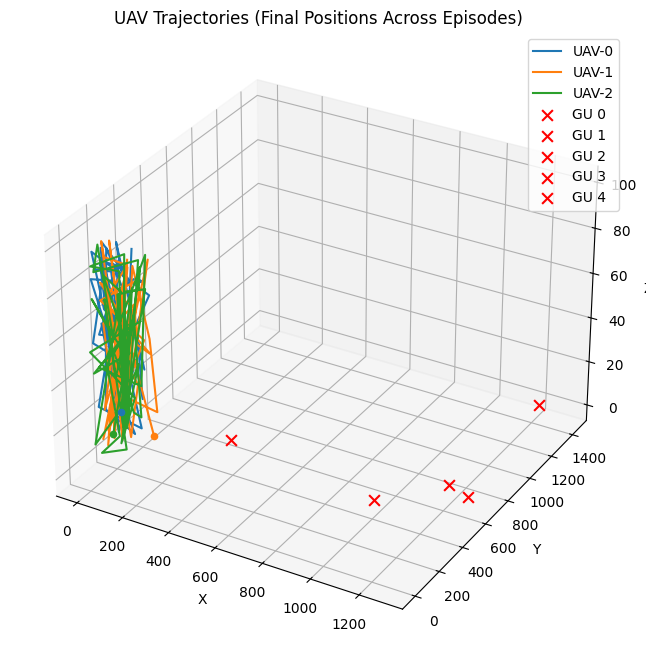

In [27]:
render_trajectories(histories)

In [72]:
%load_ext autoreload
%autoreload 2
from uav_bs_env2 import UAVSecrecyEnv

bs_env = UAVSecrecyEnv()
#bs_env = DummyVecEnv([lambda: Monitor(UAVSecrecyEnv())])
model = PPO("MlpPolicy", bs_env, verbose=0)
model.learn(total_timesteps=50000)
model.save("ppo_bs_uav_secrecy")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
rewards_uav_bs, histories_uav_bs = evaluate_agent_histories(model, bs_env, num_episodes=10000)

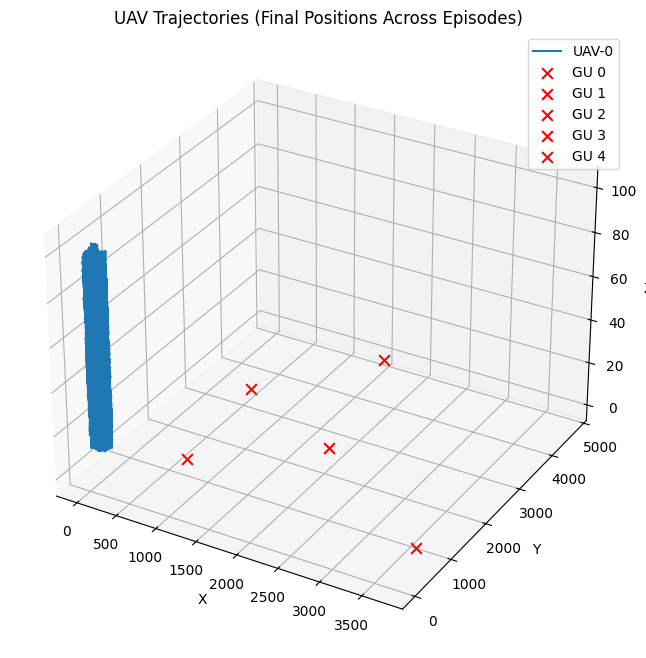

In [74]:
render_trajectories(histories_uav_bs, bs_env)

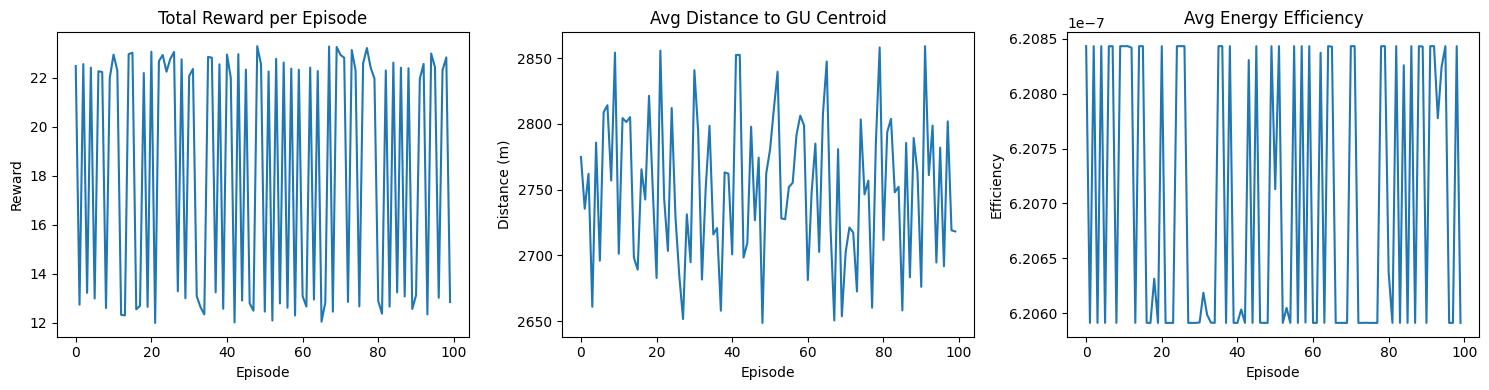

In [75]:
def evaluate_centroid_policy(model, env, num_episodes=100):
    episode_rewards = []
    episode_distances = []
    episode_energy_efficiency = []

    for ep in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0
        distances = []
        efficiencies = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward

            uav_pos = env.uavs[0].position
            centroid = np.mean([gu.position for gu in env.legit_users], axis=0)
            dist = np.linalg.norm(uav_pos - centroid)
            distances.append(dist)

            energy = env.uavs[0].compute_energy_consumption()
            efficiencies.append(1.0 / (1.0 + energy))

        episode_rewards.append(total_reward)
        episode_distances.append(np.mean(distances))
        episode_energy_efficiency.append(np.mean(efficiencies))

    return episode_rewards, episode_distances, episode_energy_efficiency

rewards, distances, efficiencies = evaluate_centroid_policy(model, bs_env)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 3, 2)
plt.plot(distances)
plt.title("Avg Distance to GU Centroid")
plt.xlabel("Episode")
plt.ylabel("Distance (m)")

plt.subplot(1, 3, 3)
plt.plot(efficiencies)
plt.title("Avg Energy Efficiency")
plt.xlabel("Episode")
plt.ylabel("Efficiency")

plt.tight_layout()
plt.show()

In [71]:
d = np.exp(-0.01 * (100)/20)
print(d * 50)

47.5614712250357


In [101]:
f = -1/np.log1p(100)
print(10 * f)

-2.1667906533553167


In [106]:
e = 100 * 1/np.log1p(100)
print(e)

21.667906533553168


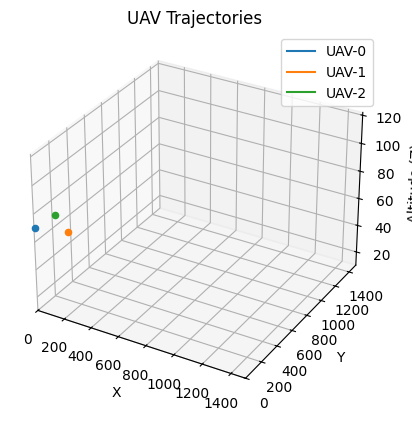

In [12]:
# After evaluating or running one episode:
render_trajectories(eval_env)

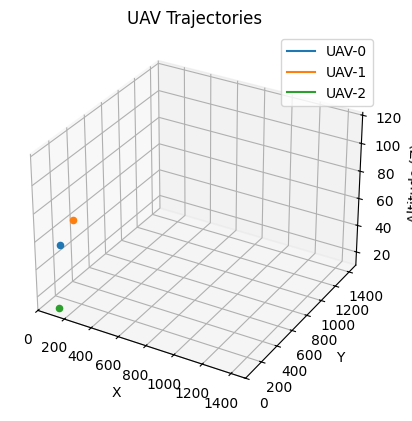

In [30]:
render_trajectories(env)

In [10]:
from collections import Counter

flat_violations = [key for v in violations for key, val in v.items() if val]
counts = Counter(flat_violations)
print("Constraint Violations Across Episodes:")
for k, v in counts.items():
    print(f"{k}: {v}")

NameError: name 'violations' is not defined

In [2]:
%load_ext autoreload
%autoreload 2
from uav_secrecy_env import UAVSecrecyEnv

env = UAVSecrecyEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)
model.save("ppo_uav_secrecy")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'PPO' is not defined